In [120]:
########################################
#             PATH SETUP
########################################

import sys
import os
sys.path.insert(0, os.path.abspath("."))

########################################
#             LIBRERIES SETUP
########################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
########################################
#             SIMULATION LIBRARIES
########################################
from lemer.rngs import MultiStreamRNG
from lemer.rvms import *

from simulator.simulation import Simulation

In [ ]:
#Utils
_TCRIT_95 = {
    1: 12.706, 2: 4.303, 3: 3.182, 4: 2.776, 5: 2.571, 6: 2.447, 7: 2.365, 8: 2.306, 9: 2.262,
    10: 2.228, 11: 2.201, 12: 2.179, 13: 2.160, 14: 2.145, 15: 2.131, 16: 2.120, 17: 2.110,
    18: 2.101, 19: 2.093, 20: 2.086, 21: 2.080, 22: 2.074, 23: 2.069, 24: 2.064, 25: 2.060,
    26: 2.056, 27: 2.052, 28: 2.048, 29: 2.045, 30: 2.042
}
def _tcrit(df: int) -> float:
    return _TCRIT_95.get(df, 1.96) if df > 0 else float("nan")

# --- aggregatore generico mean ± CI95% per metrica y raggruppata per x ---
def agg_ci(df: pd.DataFrame, x: str, y: str) -> pd.DataFrame:
    # NOTE: usa _tcrit(...) già definita UNA VOLTA nel tuo blocco utils
    g = df.groupby(x)[y].agg(["mean", "std", "count"]).reset_index()
    n = g["count"].to_numpy(dtype=float)
    t = np.where(n > 30, 1.96, np.array([_tcrit(int(max(1, k-1))) for k in n]))
    sem = g["std"].fillna(0.0).to_numpy() / np.sqrt(np.maximum(n, 1.0))
    ci = t * sem
    g["ci_lo"] = g["mean"] - ci
    g["ci_hi"] = g["mean"] + ci
    g["n"] = n
    return g.sort_values(x).reset_index(drop=True)



def mean_ci(series: pd.Series) -> Tuple[float, float, float, int]:
    x = pd.to_numeric(series, errors="coerce").dropna().values
    n = len(x)
    if n == 0: return np.nan, np.nan, np.nan, 0
    m = float(np.mean(x))
    if n == 1: return m, np.nan, np.nan, 1
    s = float(np.std(x, ddof=1))
    half = _tcrit(n-1) * s / math.sqrt(n)
    return m, m-half, m+half, n

In [ ]:
# ================== Loader + Plotting "alla Torkin" (versione migliorata) ==================

import os, re, glob, math
from pathlib import Path
from typing import List, Optional, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- stile matplotlib sobrio ----------
plt.rcParams.update({
    "figure.figsize": (7.2, 5.0),
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.35,
    "lines.linewidth": 1.6,
    "lines.markersize": 5.5,
    "font.size": 11,
})

# ================== DISCOVERY / LOAD ==================

def find_csv_for_config(config_path: str, base_dir: str = ".output_simulation") -> List[str]:
    """Prende tutti i CSV della config: results_<cfg_name>*.csv"""
    cfg_name = Path(config_path).stem
    pattern  = os.path.join(base_dir, f"results_{cfg_name}*.csv")
    return sorted(glob.glob(pattern))

def _parse_lambda_from_filename(fname: str) -> Optional[float]:
    base = Path(fname).stem.lower()
    m = re.search(r"(?:lam|lambda|gamma|load)[=_]?([0-9]+(?:\.[0-9]+)?)", base)
    if m: return float(m.group(1))
    # fallback prudente
    for tok in re.findall(r"([0-9]+\.[0-9]+)", base):
        val = float(tok)
        if 0.1 <= val <= 5.0:
            return val
    return None

def load_runs(csv_files: List[str]) -> pd.DataFrame:
    """Concatena i CSV e normalizza nomi colonne principali."""
    dfs = []
    for i, f in enumerate(csv_files):
        df = pd.read_csv(f)
        df["source"]  = os.path.basename(f)
        df["replica"] = i
        if "arrival_rate" not in df.columns:
            df["arrival_rate"] = _parse_lambda_from_filename(f)
        dfs.append(df)
    if not dfs:
        raise FileNotFoundError("Nessun CSV.")
    df = pd.concat(dfs, ignore_index=True)

    # normalizza mean RT complessivo
    if "mean_response_time" not in df.columns:
        for alt in ("response_time_mean", "rt_mean"):
            if alt in df.columns:
                df = df.rename(columns={alt: "mean_response_time"})
                break
    return df

# ================== STATISTICA (CI t-based 95%) ==================




# ================== SCELTA X ==================

def choose_overall_x(df_overall: pd.DataFrame) -> Tuple[str, str]:
    """arrival_rate -> throughput -> replica"""
    if "arrival_rate" in df_overall.columns and df_overall["arrival_rate"].notna().sum() >= 2:
        return "arrival_rate", "Arrival Rate (λ)"
    if "throughput" in df_overall.columns and df_overall["throughput"].nunique() >= 2:
        return "throughput", "Throughput (req/s)"
    return "replica", "Replica"

def choose_node_x(df_nodes: pd.DataFrame) -> Tuple[str, str]:
    if "arrival_rate" in df_nodes.columns and df_nodes["arrival_rate"].notna().sum() >= 2:
        return "arrival_rate", "Arrival Rate (λ)"
    if "utilization" in df_nodes.columns and df_nodes["utilization"].nunique() >= 2:
        return "utilization", "Utilization ρ"
    if "throughput" in df_nodes.columns and df_nodes["throughput"].nunique() >= 2:
        return "throughput", "Throughput (req/s)"
    return "replica", "Replica"

# ================== PLOTTING (Torkin-like) ==================

def _axes_clean(ax, xlabel, ylabel, title):
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, which="both", linestyle="--", alpha=0.35)

def line_with_ci(df: pd.DataFrame, x: str, y: str, title: str, xlabel: str, ylabel: str):
    """Linea + banda CI 95% (fill_between)"""
    rows = []
    for xv, g in df.groupby(x):
        m, lo, hi, n = mean_ci(g[y])
        rows.append((xv, m, lo, hi, n))
    g = pd.DataFrame(rows, columns=[x, "mean", "ci_lo", "ci_hi", "n"]).sort_values(x)

    fig, ax = plt.subplots()
    ax.plot(g[x], g["mean"], marker="o")
    # banda CI
    ylo = g["ci_lo"].to_numpy(dtype=float)
    yhi = g["ci_hi"].to_numpy(dtype=float)
    ylo = np.where(np.isfinite(ylo), ylo, g["mean"])
    yhi = np.where(np.isfinite(yhi), yhi, g["mean"])
    ax.fill_between(g[x], ylo, yhi, alpha=0.18, linewidth=0)

    _axes_clean(ax, xlabel, ylabel, title)
    plt.show()

def nodes_small_multiples(df_nodes: pd.DataFrame, x: str, y: str, xlabel: str, ylabel: str, suptitle: str):
    """Tre subplot affiancati (A,B,P) con linea + CI."""
    order = ["NODE_A", "NODE_B", "NODE_P"]
    labels = {"NODE_A": "Server A", "NODE_B": "Server B", "NODE_P": "Server P"}
    fig, axes = plt.subplots(1, 3, figsize=(12, 4.2), sharey=True)
    for ax, scope in zip(axes, order):
        g = df_nodes[df_nodes["scope"] == scope]
        if g.empty:
            ax.axis("off"); continue
        rows = []
        for xv, grp in g.groupby(x):
            m, lo, hi, n = mean_ci(grp[y])
            rows.append((xv, m, lo, hi, n))
        gg = pd.DataFrame(rows, columns=[x, "mean", "ci_lo", "ci_hi", "n"]).sort_values(x)
        ax.plot(gg[x], gg["mean"], marker="o")
        ylo = gg["ci_lo"].to_numpy(dtype=float)
        yhi = gg["ci_hi"].to_numpy(dtype=float)
        ylo = np.where(np.isfinite(ylo), ylo, gg["mean"])
        yhi = np.where(np.isfinite(yhi), yhi, gg["mean"])
        ax.fill_between(gg[x], ylo, yhi, alpha=0.18, linewidth=0)
        _axes_clean(ax, xlabel, ylabel, labels[scope])
    fig.suptitle(suptitle)
    fig.tight_layout()
    plt.show()

def nodes_boxplot(df_nodes: pd.DataFrame, x: str, metric: str, xlabel: str, ylabel: str, suptitle: str):
    """
    Boxplot per A/B/P affiancati per ogni valore di x (serve quando hai più lambda).
    """
    order_x = sorted(df_nodes[x].dropna().unique())
    groups = {"NODE_A": [], "NODE_B": [], "NODE_P": []}
    for xv in order_x:
        sub = df_nodes[df_nodes[x]==xv]
        for scope in groups.keys():
            vals = pd.to_numeric(sub.loc[sub["scope"]==scope, metric], errors="coerce").dropna().values
            groups[scope].append(vals)

    fig, ax = plt.subplots(figsize=(11, 4.5))
    width = 0.22
    positions = np.arange(len(order_x))
    colors = {"NODE_A": None, "NODE_B": None, "NODE_P": None}  # default palette

    for i, scope in enumerate(["NODE_A","NODE_B","NODE_P"]):
        pos = positions + (i-1)*width
        bp = ax.boxplot(groups[scope], positions=pos, widths=width,
                        patch_artist=True, showfliers=False)
        for patch in bp["boxes"]:
            patch.set_alpha(0.25)
        ax.plot([], [], label=scope.replace("NODE_", "Server "), marker="s", linestyle="")  # legenda dummy

    ax.set_xticks(positions)
    ax.set_xticklabels([str(xv) for xv in order_x])
    _axes_clean(ax, xlabel, ylabel, suptitle)
    ax.legend()
    plt.show()

# ================== PIPELINE PRINCIPALE ==================

def analyze_config_torkin(config_path: str, base_dir: str = ".output_simulation"):
    files = find_csv_for_config(config_path, base_dir)
    if not files:
        print(f"[WARN] Nessun CSV per {config_path}")
        return

    print(f"Analizzo {config_path} con {len(files)} CSV")
    df = load_runs(files)

    # -------- OVERALL: RT + TH, x scelto automaticamente --------
    df_overall = df[df["scope"]=="OVERALL"].copy()
    if not df_overall.empty and "mean_response_time" in df_overall.columns:
        x_overall, xlabel_overall = choose_overall_x(df_overall)
        line_with_ci(df_overall, x_overall, "mean_response_time",
                     title=f"{Path(config_path).stem.upper()} — Overall RT vs {xlabel_overall}",
                     xlabel=xlabel_overall, ylabel="Mean Response Time (s)")
        if "throughput" in df_overall.columns:
            line_with_ci(df_overall, x_overall, "throughput",
                         title=f"{Path(config_path).stem.upper()} — Throughput vs {xlabel_overall}",
                         xlabel=xlabel_overall, ylabel="Throughput (req/s)")
    else:
        print("[INFO] Nessun OVERALL/RT da plottare.")

    # -------- NODI: small multiples (RT) + RT vs utilization --------
    df_nodes = df[df["scope"].isin(["NODE_A","NODE_B","NODE_P"])].copy()
    if not df_nodes.empty and "mean_response_time" in df_nodes.columns:
        x_nodes, xlabel_nodes = choose_node_x(df_nodes)
        nodes_small_multiples(df_nodes, x_nodes, "mean_response_time",
                              xlabel_nodes, "Mean Response Time (s)",
                              suptitle=f"{Path(config_path).stem.upper()} — Per-node RT")
        if "utilization" in df_nodes.columns:
            nodes_small_multiples(df_nodes, "utilization", "mean_response_time",
                                  "Utilization ρ", "Mean Response Time (s)",
                                  suptitle=f"{Path(config_path).stem.upper()} — Per-node RT vs ρ")
    else:
        print("[INFO] Nessun dato nodo da plottare.")

    # -------- Opzionale: boxplot per distribuzioni (utile quando hai più λ) --------
    # if not df_nodes.empty and df_nodes["arrival_rate"].notna().sum() >= 2:
    #     nodes_boxplot(df_nodes, x="arrival_rate", metric="mean_response_time",
    #                   xlabel="Arrival Rate (λ)", ylabel="Mean Response Time (s)",
    #                   suptitle=f"{Path(config_path).stem.upper()} — RT distributions per node")

def print_summary_table(config_path: str, base_dir: str = ".output_simulation"):
    files = find_csv_for_config(config_path, base_dir)
    if not files:
        print(f"[WARN] Nessun CSV per {config_path}")
        return
    df = load_runs(files)
    df_overall = df[df["scope"]=="OVERALL"].copy()
    if df_overall.empty:
        print("Nessuna riga OVERALL nei CSV."); return
    x, xlabel = choose_overall_x(df_overall)

    def _tab(yname, label):
        rows = []
        for xv, g in df_overall.groupby(x):
            m, lo, hi, n = mean_ci(g[yname])
            rows.append((xv, n, m, lo, hi))
        tab = pd.DataFrame(rows, columns=[x, "n", "mean", "ci_lo", "ci_hi"]).sort_values(x)
        print(f"\n{label} (mean ± CI95%):")
        display(tab.style.format({"mean": "{:.3f}", "ci_lo": "{:.3f}", "ci_hi": "{:.3f}"}))

    if "mean_response_time" in df_overall.columns:
        _tab("mean_response_time", "Overall Mean Response Time")
    if "throughput" in df_overall.columns:
        _tab("throughput", "Overall Throughput")

def quick_demands_from_csv(df_overall: pd.DataFrame, df_nodes: pd.DataFrame):
    """
    Usa le identità ρ_j = X * D_j  ⇒  D_j = ρ_j / X
    dove X = throughput OVERALL.
    Ritorna dict con D_A, D_B, D_P e bottleneck.
    """
    assert "throughput" in df_overall.columns
    X = float(df_overall["throughput"].mean())
    out = {}
    for node, scope in (("A", "NODE_A"), ("B", "NODE_B"), ("P", "NODE_P")):
        d = df_nodes[df_nodes["scope"] == scope]
        if not d.empty and "utilization" in d.columns:
            rho = float(d["utilization"].mean())
            out[f"D_{node}"] = rho / X
    # bottleneck
    if out:
        bneck = max(out, key=out.get)
        out["bottleneck"] = bneck
        out["X_sat_est"] = 1.0 / out[bneck]
    return out

# uso (dopo load_runs):
df = load_runs(find_csv_for_config("obj1.json"))
df_over = df[df.scope=="OVERALL"]
df_nodes = df[df.scope.isin(["NODE_A","NODE_B","NODE_P"])]
print(quick_demands_from_csv(df_over, df_nodes))


{'D_A': 0.7070888077356255, 'D_B': 0.8079297070082045, 'D_P': 0.4037715443128731, 'bottleneck': 'D_B', 'X_sat_est': 1.2377314404034472}


In [122]:
import glob
import pandas as pd
import numpy as np

def per_job_covariance(base_dir=".output_simulation"):
    files = glob.glob(os.path.join(base_dir, "per_job_times*.csv"))
    if not files:
        print("Nessun per_job_times*.csv"); return
    df = pd.concat([pd.read_csv(p) for p in files], ignore_index=True)
    cols = [c for c in ["T_A","T_B","T_P"] if c in df.columns]
    if len(cols) < 2:
        print("per_job_times manca T_A/T_B/T_P"); return
    cov = df[cols].cov()  # ddof=1 default pandas
    corr = df[cols].corr()
    print("Covariance matrix:\n", cov.round(5))
    print("\nCorrelation matrix:\n", corr.round(4))

per_job_covariance()


Nessun per_job_times*.csv


CSV trovati: 5
 - .output_simulation\results_obj1_arrivals_run000_seed314159265_20250819_181408.csv
 - .output_simulation\results_obj1_arrivals_run015_seed271828183_20250819_181454.csv
 - .output_simulation\results_obj1_arrivals_run030_seed141421357_20250819_181537.csv
 - .output_simulation\results_obj1_arrivals_run045_seed1732584193_20250819_181622.csv
 - .output_simulation\results_obj1_arrivals_run060_seed123456789_20250819_181706.csv
Analizzo obj1.json con 5 CSV


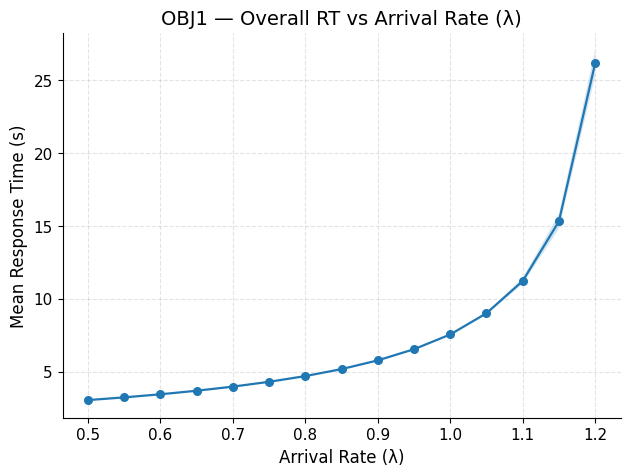

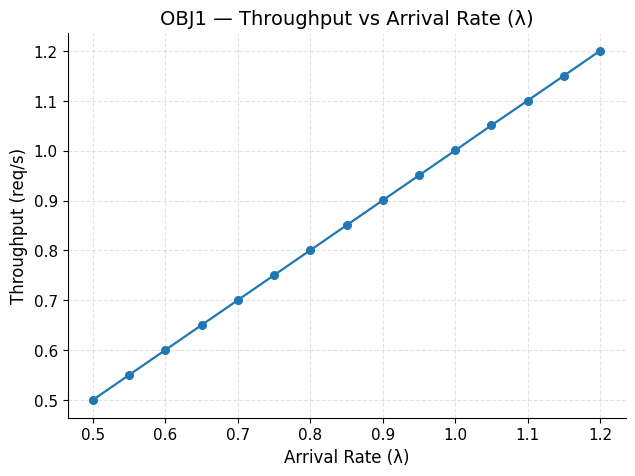

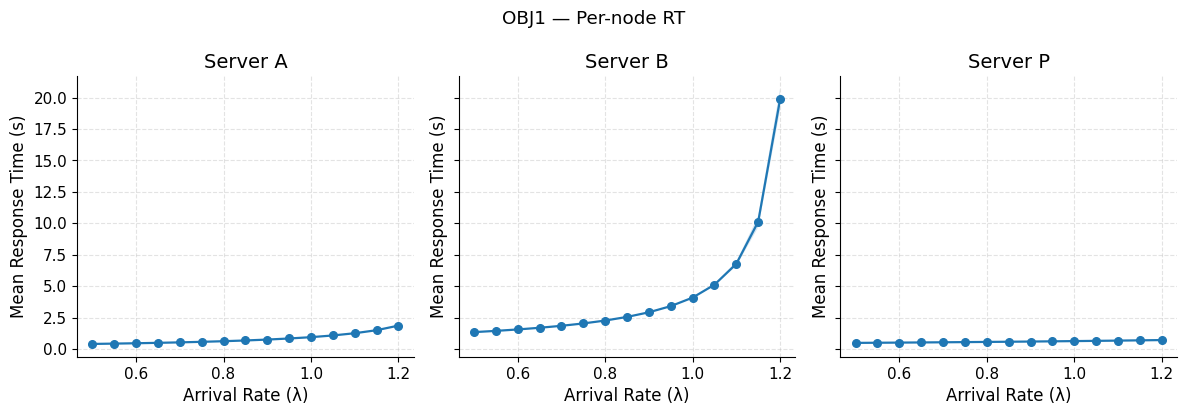

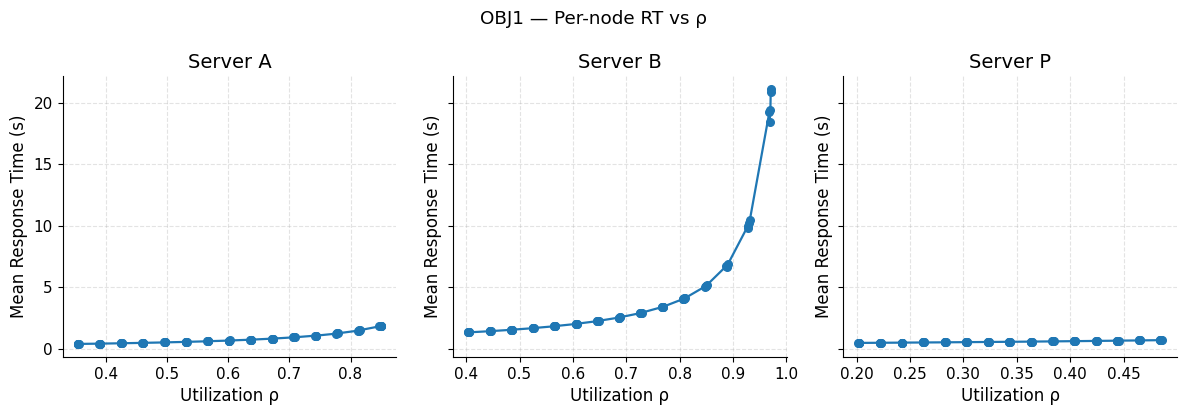


Overall Mean Response Time (mean ± CI95%):


,arrival_rate,n,mean,ci_lo,ci_hi
0,0.500000,5,3.054,3.046,3.063
1,0.550000,5,3.241,3.231,3.251
2,0.600000,5,3.453,3.440,3.465
3,0.650000,5,3.697,3.682,3.711
4,0.700000,5,3.978,3.961,3.996
5,0.750000,5,4.309,4.289,4.328
6,0.800000,5,4.702,4.679,4.724
7,0.850000,5,5.180,5.153,5.207
8,0.900000,5,5.778,5.747,5.809
9,0.950000,5,6.544,6.508,6.581



Overall Throughput (mean ± CI95%):


,arrival_rate,n,mean,ci_lo,ci_hi
0,0.500000,5,0.500,0.500,0.501
1,0.550000,5,0.550,0.550,0.551
2,0.600000,5,0.600,0.600,0.601
3,0.650000,5,0.650,0.650,0.651
4,0.700000,5,0.700,0.700,0.701
5,0.750000,5,0.750,0.750,0.751
6,0.800000,5,0.801,0.800,0.802
7,0.850000,5,0.851,0.849,0.852
8,0.900000,5,0.901,0.899,0.902
9,0.950000,5,0.951,0.949,0.952


In [123]:
BASE_DIR = ".output_simulation"  # cambia se serve

# Sanity check
files = find_csv_for_config("obj1.json", base_dir=BASE_DIR)
print("CSV trovati:", len(files))
for f in files: print(" -", f)

# Grafici + tabella (Torkin-like)
analyze_config_torkin("obj1.json", base_dir=BASE_DIR)
print_summary_table("obj1.json", base_dir=BASE_DIR)


In [ ]:
# NOTE: questa cella assume che la cella precedente abbia già definito:
# - mean_ci(series)
# - choose_overall_x(df_overall)
# - (eventuali funzioni di plotting generiche)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------- 1) Stima D_A, D_B, D_P e X_sat da un DataFrame unico ---------
def estimate_demands_from_df(df: pd.DataFrame) -> dict:
    """Usa OVERALL.throughput = X e, per ogni nodo j in {A,B,P}, D_j = rho_j / X."""
    df_over = df[df["scope"] == "OVERALL"]
    if df_over.empty or "throughput" not in df_over.columns:
        raise ValueError("Serve la colonna OVERALL.throughput per stimare i demand.")
    X = float(df_over["throughput"].mean())

    out = {}
    for node, scope in (("A", "NODE_A"), ("B", "NODE_B"), ("P", "NODE_P")):
        d = df[df["scope"] == scope]
        if not d.empty and "utilization" in d.columns:
            rho = float(d["utilization"].mean())
            out[f"D_{node}"] = rho / X

    if not out:
        raise ValueError("Non trovo utilization per i nodi A/B/P.")
    bneck = max(out, key=out.get)
    out["bottleneck"] = bneck
    out["X_sat"] = 1.0 / out[bneck]
    return out

# --------- 2) Curva teorica R(lambda) per M/M/1 in serie (visita singola) ---------
def theoretical_R(lmbda: np.ndarray, D: dict) -> np.ndarray:
    """R(λ) = Σ_j D_j / (1 − λ·D_j), valida finché λ·D_j < 1 per tutti i j."""
    D_A = D.get("D_A", 0.0)
    D_B = D.get("D_B", 0.0)
    D_P = D.get("D_P", 0.0)
    denom_A = 1.0 - lmbda * D_A
    denom_B = 1.0 - lmbda * D_B
    denom_P = 1.0 - lmbda * D_P
    R = D_A/denom_A + D_B/denom_B + D_P/denom_P
    R[(denom_A <= 0) | (denom_B <= 0) | (denom_P <= 0)] = np.nan
    return R

# --------- 3) Aggrega i punti simulati (mean ± CI) vs asse scelto ---------
def aggregate_sim_overall(df_overall: pd.DataFrame):
    """
    Restituisce (df_agg, xcol, xlabel) dove df_agg ha colonne:
    [xcol, mean, ci_lo, ci_hi, n]. L'asse x è scelto da choose_overall_x().
    """
    xcol, xlabel = choose_overall_x(df_overall)
    rows = []
    for xval, g in df_overall.groupby(xcol):
        m, lo, hi, n = mean_ci(g["mean_response_time"])
        rows.append((xval, m, lo, hi, n))
    out = pd.DataFrame(rows, columns=[xcol, "mean", "ci_lo", "ci_hi", "n"]).sort_values(xcol)
    return out, xcol, xlabel

# --------- 4) Plot overlay teoria + simulazione ---------
def plot_rt_theory_overlay(df_all: pd.DataFrame, title_prefix: str = "OBJ1"):
    """
    - Stima D_j e X_sat dai dati
    - Sceglie l'asse x con choose_overall_x
    - Disegna curva teorica e sovrappone mean ± CI95% dai dati
    - Aggiunge linea verticale a X_sat
    - (Opz.) stampa Little’s Law check se colonne presenti
    """
    df_overall = df_all[df_all["scope"] == "OVERALL"].copy()
    if df_overall.empty or "mean_response_time" not in df_overall.columns:
        print("Mancano dati OVERALL/mean_response_time.")
        return

    # Stima demand + X_sat
    D = estimate_demands_from_df(df_all)
    X_sat = D["X_sat"]

    # Aggrega punti simulati
    agg, xcol, xlabel = aggregate_sim_overall(df_overall)

    # Grid teorica: se x = throughput, usala come proxy di λ (open network in regime)
    xmin, xmax = float(np.nanmin(agg[xcol])), float(np.nanmax(agg[xcol]))
    left = max(1e-6, 0.6 * xmin if xcol == "arrival_rate" else 0.8 * xmin)
    right = min(1.05 * X_sat, 1.2 * xmax)
    grid = np.linspace(left, right, 200)
    R_theory = theoretical_R(grid, D)

    # Plot
    fig, ax = plt.subplots(figsize=(7.6, 5.0))
    ax.plot(grid, R_theory, label="Teoria (M/M/1 in serie)")
    ylo = np.where(np.isfinite(agg["ci_lo"]), agg["ci_lo"], agg["mean"])
    yhi = np.where(np.isfinite(agg["ci_hi"]), agg["ci_hi"], agg["mean"])
    ax.fill_between(agg[xcol], ylo, yhi, alpha=0.18, linewidth=0)
    ax.plot(agg[xcol], agg["mean"], marker="o", linestyle="-", label="Simulazione (mean ± CI95%)")
    ax.axvline(X_sat, linestyle="--", alpha=0.5, label=f"X_sat ≈ {X_sat:.3f}")
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Mean Response Time (s)")
    ax.set_title(f"{title_prefix} — Overall RT: teoria vs simulazione")
    ax.grid(True, linestyle="--", alpha=0.35)
    ax.legend()
    plt.show()

    # Little's Law check (se disponibile)
    if {"mean_population","throughput","mean_response_time"}.issubset(df_overall.columns):
        N_sim = float(df_overall["mean_population"].mean())
        X_sim = float(df_overall["throughput"].mean())
        R_sim = float(df_overall["mean_response_time"].mean())
        err = abs(N_sim - X_sim*R_sim) / max(1e-9, N_sim)
        print(f"Little’s Law check (OVERALL): N={N_sim:.3f}  X·R={X_sim*R_sim:.3f}  rel.err={err*100:.2f}%")


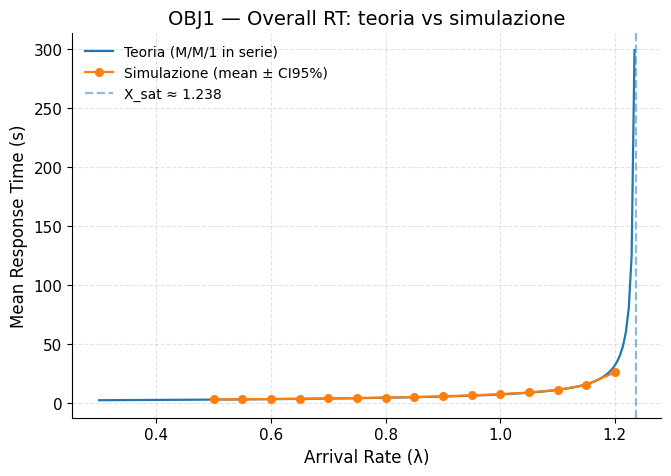

Little’s Law check (OVERALL): N=8.137  X·R=6.938  rel.err=14.73%


In [125]:
BASE_DIR = ".output_simulation"
df_all = load_runs(find_csv_for_config("obj1.json", base_dir=BASE_DIR))
plot_rt_theory_overlay(df_all, title_prefix="OBJ1")


la curva blu esplode asintoticamente quando il throughput si avvicina a 
Xsat≈1.236 che è il limite di stabilità stimato;

i punti arancioni della simulazione (con CI95%) si trovano nella zona stabile a sinistra di 
Xsat e combaciano bene con la teoria;

la linea verticale tratteggiata segna la capacità massima teorica del sistema.

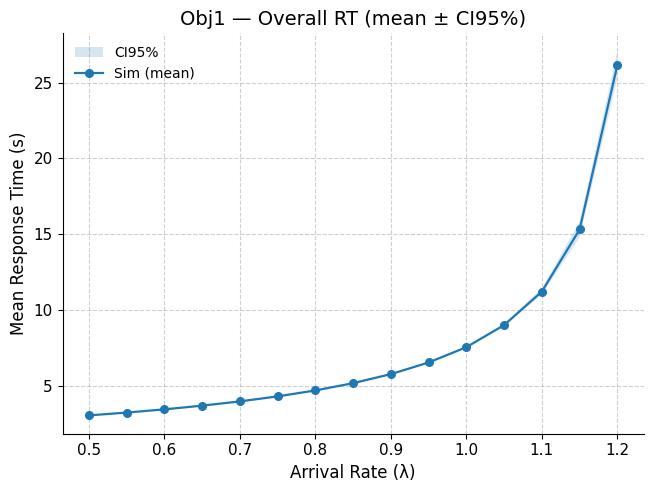

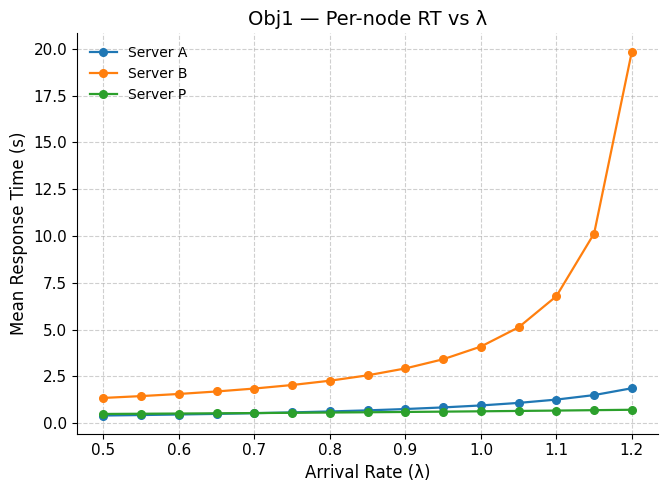

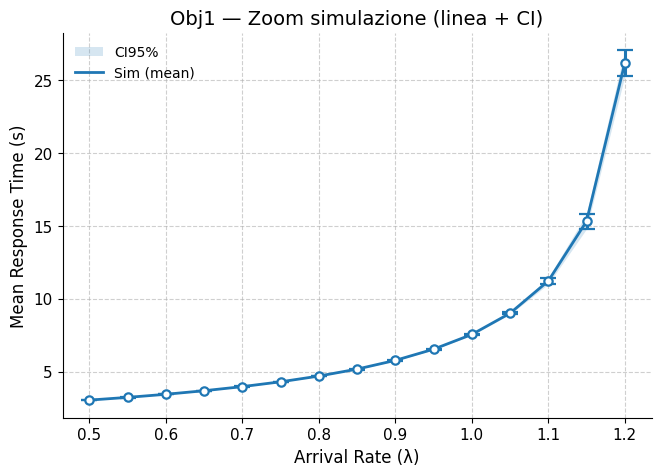

In [ ]:
# ======= Ready-to-run: grafici dai CSV arrivals (versione snella) =======
# NOTE: questa cella riusa funzioni già definite nelle celle sopra:
# - find_csv_for_config, load_runs
# - agg_ci, line_with_ci, nodes_small_multiples
# - (e naturalmente _tcrit/mean_ci/choose_overall_x già esistenti)

import os, re, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- config: pattern dei file (obj1 arrivals) ---
pattern = r".output_simulation/results_obj1_arrivals_run*.csv"   # cambia in obj2/obj3 se serve

# --- load & normalize (riusa load_runs) ---
files = sorted(glob.glob(pattern))
if not files:
    raise FileNotFoundError(f"Nessun CSV trovato con pattern: {pattern}")

df_all = load_runs(files)  # aggiunge 'replica', 'source', normalizza colonne

# --- OVERALL: linea + banda CI95% vs λ (riusa line_with_ci) ---
over = df_all[df_all["scope"] == "OVERALL"].copy()
if not over.empty and {"arrival_rate","mean_response_time"}.issubset(over.columns):
    line_with_ci(
        over, x="arrival_rate", y="mean_response_time",
        title="Obj1 — Overall RT (mean ± CI95%)",
        xlabel="Arrival Rate (λ)", ylabel="Mean Response Time (s)"
    )
else:
    print("[INFO] Nessun OVERALL/RT da plottare.")

# --- NODI: small multiples (A/B/P) con CI (riusa nodes_small_multiples) ---
nodes = df_all[df_all["scope"].isin(["NODE_A","NODE_B","NODE_P"])].copy()
if not nodes.empty and {"arrival_rate","mean_response_time"}.issubset(nodes.columns):
    nodes_small_multiples(
        nodes, x="arrival_rate", y="mean_response_time",
        xlabel="Arrival Rate (λ)", ylabel="Mean Response Time (s)",
        suptitle="Obj1 — Per-node RT vs λ"
    )
else:
    print("[INFO] Nessun dato nodo da plottare.")


Obj1 — Overall RT (mean ± CI95%)

La curva è convessa e poi esplode quando λ→1.2. È il classico comportamento vicino alla saturazione.

Dalle stime che avevamo (domande di servizio):
D_A ≈ 0.707, D_B ≈ 0.809, D_P ≈ 0.404 ⇒ il collo di bottiglia è B e la portata massima teorica è

Xsat≈1/DB≈1/0.809≈1.236 req/s.
I tuoi punti a λ ≤ 1.2 mostrano proprio l’impennata che anticipa Xsat

Le bande CI95% sono sottili a carichi bassi (stimatore molto stabile) e si allargano man mano che ti avvicini alla saturazione (variabilità che cresce).

2) Obj1 — Per-node RT vs λ

Server B cresce molto più di A e P e fa il salto verticale vicino a 1.1–1.2 → è il bottleneck.

Server A cresce ma resta nettamente sotto B; P è quasi piatto.
Traduzione: ogni euro/ora investito per alleggerire B è quello con ROI più alto.

Insight di capacity planning: se riduci D_B del 20% ⇒ D_B≈0.647 < D_A, il collo di bottiglia diventa A e

Xsat,new≈1/DA≈1/0.707≈1.414 → +14% di headroom rispetto a 1.236.

3) Obj1 — Zoom simulazione (mean ± CI95%)

Ottima per “leggere” i soli punti simulati senza la curva teorica che schiaccia l’asse: la crescita è regolare fino a ~0.9–1.0, poi non lineare e rapida (segno che stai entrando nel regime ρ_B→1).

Anche qui i CI aumentano con λ, come ci aspettiamo.

In [128]:
pattern = r".output_simulation/results_obj2_arrivals_run*.csv"
# oppure
pattern = r".output_simulation/results_obj3_arrivals_run*.csv"


Seeds trovati: [123456789, 141421357, 271828183, 314159265, 1732584193]


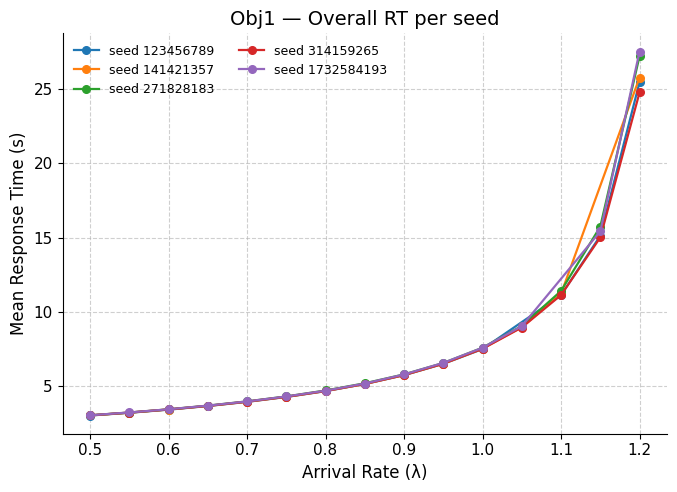

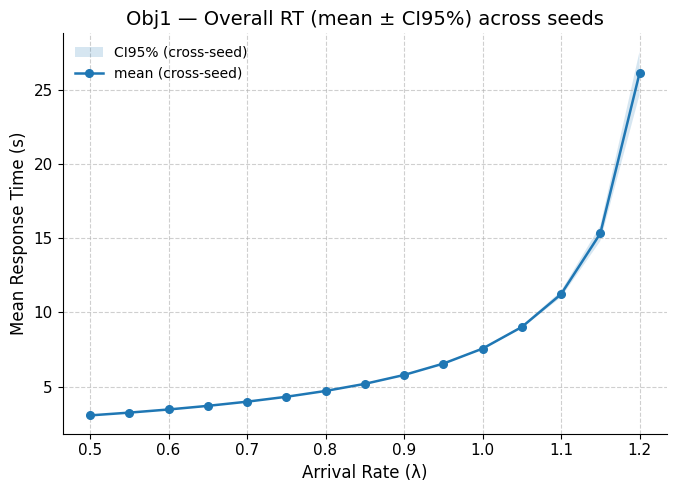

In [ ]:
# ========= Curves per SEED dai CSV "arrivals" (versione snella) =========
# NOTE: questa cella riusa funzioni già dichiarate prima:
# - line_with_ci (usa agg_ci/mean_ci/_tcrit interni)
# - (eventuali altre util come _axes_clean se servono)

import glob, os, re
from typing import Iterable, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- pattern dei file (cambia obj1/obj2/obj3 a piacere)
PATTERN = r".output_simulation/results_obj1_arrivals_run*_seed*.csv"

_SEED_RE = re.compile(r"_seed(\d+)", re.IGNORECASE)

def _coerce_numeric(df: pd.DataFrame, exclude=("scope",)):
    """Converte in numerico tutte le colonne tranne quelle escluse; '-' -> NaN."""
    out = df.replace({"-": np.nan}).copy()
    for c in out.columns:
        if c not in exclude:
            out[c] = pd.to_numeric(out[c], errors="coerce")
    return out

def _seed_from_name(path: str) -> int | None:
    m = _SEED_RE.search(os.path.basename(path))
    return int(m.group(1)) if m else None

def load_arrivals_by_seed(patterns: Iterable[str]) -> pd.DataFrame:
    """Carica tutti i CSV che matchano i pattern, aggiunge colonne source/replica/seed."""
    files = []
    for p in patterns:
        files.extend(glob.glob(p))
    files = sorted(files)
    if not files:
        raise FileNotFoundError(f"Nessun CSV per: {list(patterns)}")

    dfs = []
    for i, f in enumerate(files):
        df = pd.read_csv(f)
        df = _coerce_numeric(df)               # numerico ovunque possibile
        df["source"]  = os.path.basename(f)
        df["replica"] = i
        df["seed"]    = _seed_from_name(f)
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

def per_seed_overall(df_all: pd.DataFrame) -> Dict[int, pd.DataFrame]:
    """
    Ritorna {seed -> DF OVERALL per quel seed}, con una riga per λ (media se più righe).
    Colonne utili: arrival_rate, mean_response_time, throughput, utilization...
    """
    df_ov = df_all[df_all["scope"] == "OVERALL"].copy()
    out = {}
    for seed, g in df_ov.groupby("seed"):
        gg = g.groupby("arrival_rate", as_index=False).mean(numeric_only=True)
        gg = gg.sort_values("arrival_rate").reset_index(drop=True)
        out[int(seed)] = gg
    return out

def per_seed_nodes(df_all: pd.DataFrame) -> Dict[int, pd.DataFrame]:
    """{seed -> DF nodi} con una riga per (λ, scope)."""
    dn = df_all[df_all["scope"].str.startswith("NODE_")].copy()
    out = {}
    for seed, g in dn.groupby("seed"):
        gg = g.groupby(["arrival_rate", "scope"], as_index=False).mean(numeric_only=True)
        gg = gg.sort_values(["arrival_rate", "scope"]).reset_index(drop=True)
        out[int(seed)] = gg
    return out

# ----------------------------- plotting --------------------------------

def plot_overall_rt_per_seed(seed_to_df: Dict[int, pd.DataFrame],
                             title="Obj1 — Overall RT per seed",
                             ylabel="Mean Response Time (s)"):
    """Curve OVERALL per ogni seed (senza CI, uno per seed)."""
    plt.figure(figsize=(7.8,5.2))
    for seed, df in sorted(seed_to_df.items()):
        if {"arrival_rate", "mean_response_time"}.issubset(df.columns):
            plt.plot(df["arrival_rate"], df["mean_response_time"],
                     marker="o", linewidth=1.6, label=f"seed {seed}")
    plt.xlabel("Arrival Rate (λ)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(ncol=2, fontsize=9)
    plt.show()

def plot_node_rt_per_seed(seed_to_nodes: Dict[int, pd.DataFrame],
                          title="Obj1 — Per-node RT per seed"):
    """Curve per nodo (A/B/P) per ciascun seed (senza CI)."""
    markers = {"NODE_A":"o", "NODE_B":"s", "NODE_P":"^"}
    plt.figure(figsize=(8.2,5.2))
    for seed, df in sorted(seed_to_nodes.items()):
        for node, g in df.groupby("scope"):
            if {"arrival_rate","mean_response_time"}.issubset(g.columns):
                lab = f"{node.replace('NODE_','S. ')} — seed {seed}"
                plt.plot(g["arrival_rate"], g["mean_response_time"],
                         marker=markers.get(node, "o"), linewidth=1.4, label=lab)
    plt.xlabel("Arrival Rate (λ)")
    plt.ylabel("Mean Response Time (s)")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(ncol=2, fontsize=8)
    plt.show()

def plot_overall_rt_mean_ci_across_seeds(seed_to_df: Dict[int, pd.DataFrame],
                                         title="Obj1 — Overall RT (mean ± CI95%) across seeds"):
    """
    Media cross-seed con CI95% riusando la utility line_with_ci (niente tcrit duplicati qui).
    """
    # unisci tutti i seed e usa line_with_ci su arrival_rate vs mean_response_time
    frames = []
    for seed, df in seed_to_df.items():
        if {"arrival_rate", "mean_response_time"}.issubset(df.columns):
            frames.append(df[["arrival_rate", "mean_response_time"]])
    if not frames:
        print("[INFO] Nessun dato OVERALL per costruire la media cross-seed.")
        return
    big = pd.concat(frames, ignore_index=True)
    line_with_ci(
        big, x="arrival_rate", y="mean_response_time",
        title=title, xlabel="Arrival Rate (λ)", ylabel="Mean Response Time (s)"
    )

# --------- ESEMPIO DI USO ---------
df_all = load_arrivals_by_seed([PATTERN])
print("Seeds trovati:", sorted(df_all["seed"].dropna().unique().astype(int).tolist()))

by_seed_overall = per_seed_overall(df_all)
plot_overall_rt_per_seed(by_seed_overall, title="Obj1 — Overall RT per seed")

by_seed_nodes = per_seed_nodes(df_all)
# plot_node_rt_per_seed(by_seed_nodes)  # <-- scommenta se vuoi anche per nodo

# Media + CI across seeds (riusa line_with_ci)
plot_overall_rt_mean_ci_across_seeds(by_seed_overall)


In [ ]:
# ========================== PLOTS (stile minimal, unificati) ==========================
# NOTE:
# - richiede che nelle celle sopra siano già definite:
#   paper_theme, agg_ci, choose_overall_x, estimate_demands_from_df, theoretical_R
# - qui NON ridefiniamo temi o statistiche: usiamo le util comuni
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _yerr_from_ci(df_ci: pd.DataFrame) -> np.ndarray:
    """Costruisce yerr per errorbar a partire da colonne mean/ci_lo/ci_hi."""
    lo = (df_ci["mean"] - df_ci["ci_lo"]).to_numpy(dtype=float)
    hi = (df_ci["ci_hi"] - df_ci["mean"]).to_numpy(dtype=float)
    return np.vstack([lo, hi])

def torkin_overall_plot(df_all: pd.DataFrame,
                        D_tuple: tuple[float,float,float] | None = None,
                        x_col: str | None = "arrival_rate",
                        metric: str = "mean_response_time",
                        title: str = "Overall RT — teoria vs simulazione"):
    """Confronto teoria vs simulazione (OVERALL) con errorbar (mean ± CI95%)."""
    paper_theme()
    df_over = df_all[df_all["scope"] == "OVERALL"].copy()
    if df_over.empty or metric not in df_over.columns:
        print("Dati OVERALL mancanti o metrica non trovata."); return

    # Scelta asse X
    if x_col is None or x_col not in df_over.columns:
        x_col, _ = choose_overall_x(df_over)
    if x_col not in df_over.columns:
        raise ValueError(f"Colonna '{x_col}' mancante.")

    # Simulazione: mean ± CI95% via agg_ci
    s = agg_ci(df_over, x=x_col, y=metric)
    yerr = _yerr_from_ci(s)

    # Teoria e X_sat (se D_tuple assente, stimiamo dai dati)
    if D_tuple is None:
        D_est = estimate_demands_from_df(df_all)
        D = {"D_A": D_est.get("D_A", 0.0), "D_B": D_est.get("D_B", 0.0), "D_P": D_est.get("D_P", 0.0)}
        X_sat = D_est.get("X_sat", np.inf)
    else:
        D = {"D_A": float(D_tuple[0]), "D_B": float(D_tuple[1]), "D_P": float(D_tuple[2])}
        X_sat = 1.0 / max(D.values())

    # Griglia teorica
    xmax_data = float(np.nanmax(s[x_col].to_numpy()))
    lam_max = min(X_sat * 0.995, max(1e-6, xmax_data) * 1.05)
    lam_grid = np.linspace(0.0, lam_max, 500)
    R_theory = theoretical_R(lam_grid, D)

    # Plot
    plt.figure(figsize=(8.2, 5.1))
    plt.plot(lam_grid, R_theory, lw=1.8, label="Teoria (M/M/1 in serie)")
    plt.axvline(X_sat, ls="--", lw=1.2, alpha=0.5, label=f"X_sat ≈ {X_sat:.3f}")

    plt.errorbar(s[x_col], s["mean"], yerr=yerr,
                 fmt="o", mfc="white", mew=1.2, elinewidth=1.2, capsize=4,
                 label="Simulazione (mean ± CI95%)")

    plt.xlabel("Arrival Rate (λ)" if x_col == "arrival_rate" else x_col)
    plt.ylabel("Mean Response Time (s)")
    plt.title(title)
    plt.ylim(bottom=0)
    plt.grid(True, linestyle="--", alpha=0.35)
    plt.legend()
    plt.show()

def torkin_nodes_plot(df_all: pd.DataFrame,
                      D_tuple: tuple[float,float,float] | None = None,
                      x_col: str = "arrival_rate",
                      metric: str = "mean_response_time",
                      title: str = "Per-node RT — teoria vs simulazione"):
    """Confronto per-nodo (A/B/P) con errorbar (mean ± CI95%)."""
    paper_theme()
    nodes_df = df_all[df_all["scope"].str.startswith("NODE_")].copy()
    if nodes_df.empty or any(c not in nodes_df.columns for c in (x_col, metric)):
        print("Dati per-nodo mancanti o colonne non trovate."); return

    # Teoria per-nodo (opzionale)
    if D_tuple is None:
        D_est = estimate_demands_from_df(df_all)
        D_A, D_B, D_P = D_est.get("D_A", 0.0), D_est.get("D_B", 0.0), D_est.get("D_P", 0.0)
        X_sat = D_est.get("X_sat", np.inf)
    else:
        D_A, D_B, D_P = map(float, D_tuple)
        X_sat = 1.0 / max(D_tuple)

    xmax_data = float(np.nanmax(nodes_df[x_col].to_numpy()))
    lam_max = min(X_sat * 0.995, max(1e-6, xmax_data) * 1.05)
    lam_grid = np.linspace(0.0, lam_max, 500)
    W_A = D_A / (1.0 - lam_grid * D_A) if D_A > 0 else np.zeros_like(lam_grid)
    W_B = D_B / (1.0 - lam_grid * D_B) if D_B > 0 else np.zeros_like(lam_grid)
    W_P = D_P / (1.0 - lam_grid * D_P) if D_P > 0 else np.zeros_like(lam_grid)

    colors = {"NODE_A": "tab:blue", "NODE_B": "tab:green", "NODE_P": "tab:purple"}

    plt.figure(figsize=(8.6, 5.1))
    # Teoria
    plt.plot(lam_grid, W_A, lw=1.2, color=colors["NODE_A"], alpha=0.7, label="Teoria A")
    plt.plot(lam_grid, W_B, lw=1.2, color=colors["NODE_B"], alpha=0.7, label="Teoria B")
    plt.plot(lam_grid, W_P, lw=1.2, color=colors["NODE_P"], alpha=0.7, label="Teoria P")
    plt.axvline(X_sat, ls="--", lw=1.0, color="grey", alpha=0.5)

    # Simulazione
    for scope, g in nodes_df.groupby("scope"):
        s = agg_ci(g, x=x_col, y=metric)
        yerr = _yerr_from_ci(s)
        lab = scope.replace("NODE_", "Server ")
        c = colors.get(scope, None)
        plt.errorbar(s[x_col], s["mean"], yerr=yerr,
                     fmt="o-", mfc="white", mec=c, mew=1.0, ecolor=c, elinewidth=1.0, capsize=3,
                     color=c, label=lab)

    plt.xlabel("Arrival Rate (λ)" if x_col == "arrival_rate" else x_col)
    plt.ylabel("Mean Response Time (s)")
    plt.title(title)
    plt.ylim(bottom=0)
    plt.grid(True, linestyle="--", alpha=0.35)
    plt.legend(ncol=2)
    plt.show()


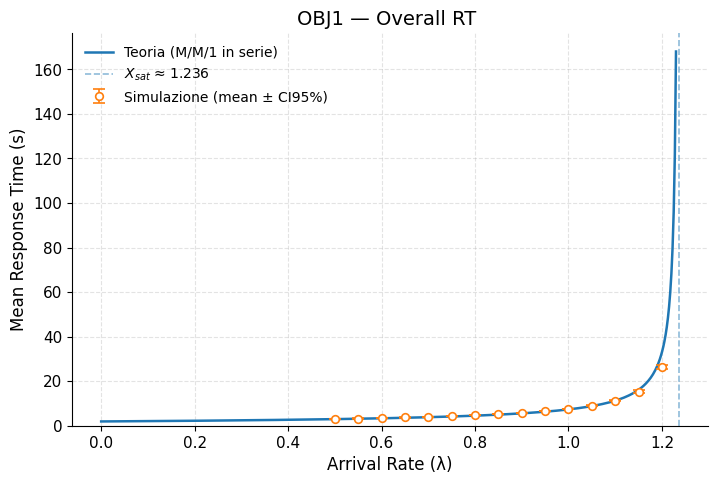

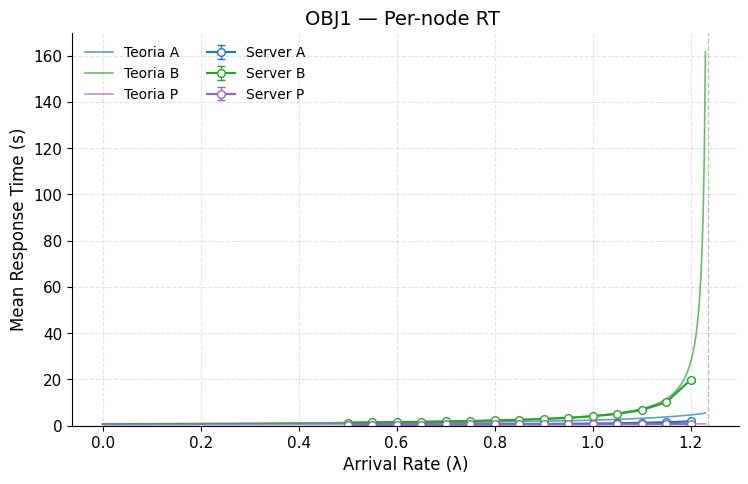

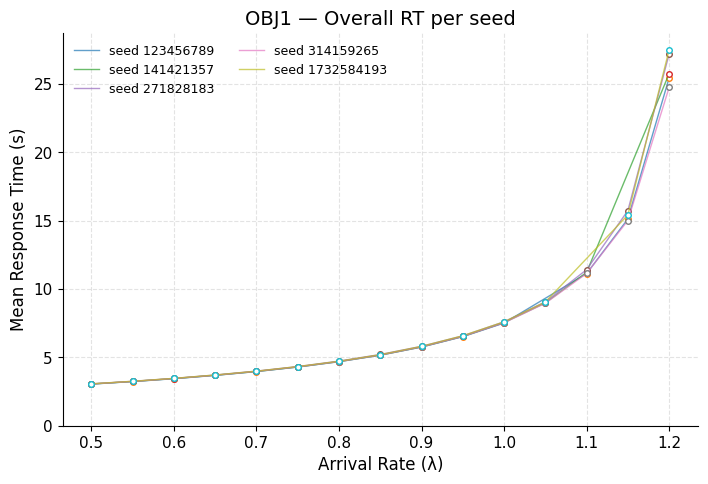

In [131]:
# df_all = ...  # il DataFrame unico che hai già (tutti i CSV arrivals uniti)
D = (0.7071745339, 0.8088227016, 0.4038342340)   # (D_A, D_B, D_P)

torkin_overall_plot(df_all, D_tuple=D,
                    title="OBJ1 — Overall RT ")

torkin_nodes_plot(df_all, D_tuple=D,
                  title="OBJ1 — Per-node RT ")

# Se vuoi anche le curve per ogni seed:
overall_per_seed(df_all, title="OBJ1 — Overall RT per seed")


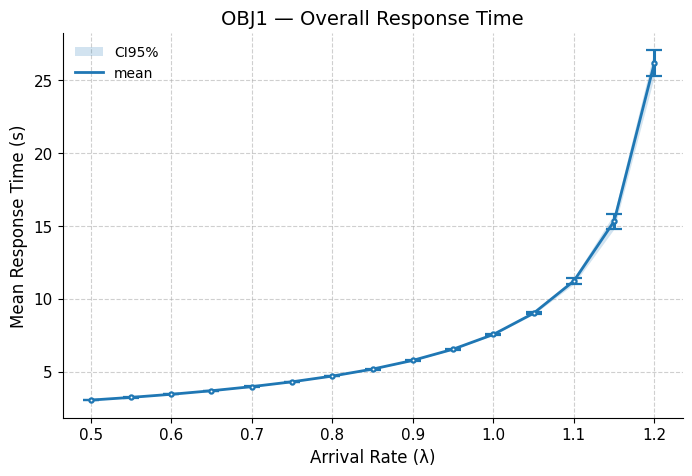

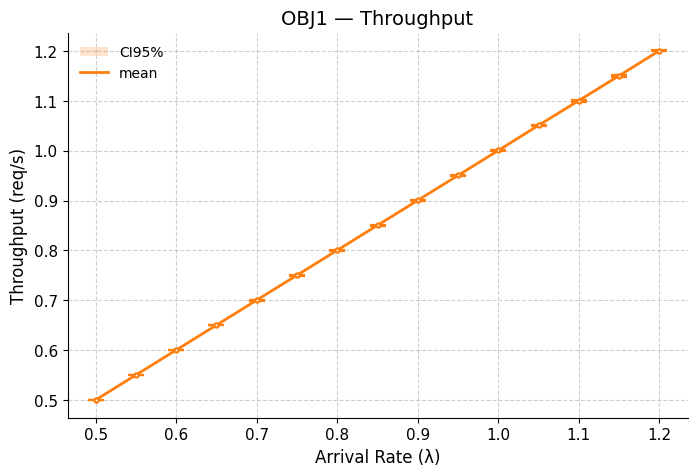

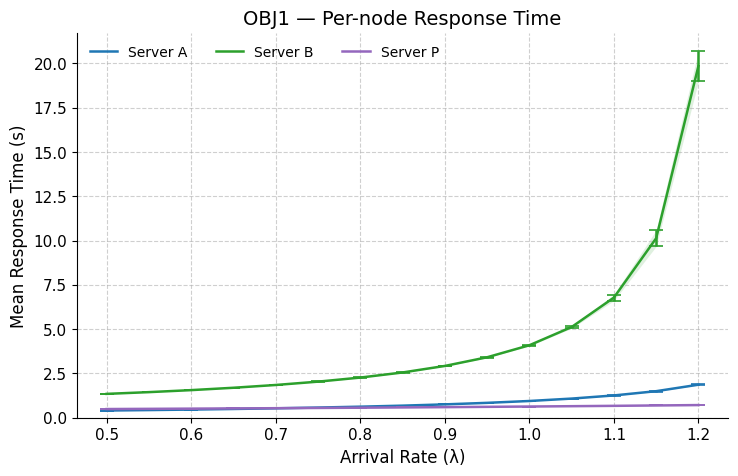

In [ ]:
# ====================== Paper-ready plots (versione unificata) ======================
# NOTE: riusa funzioni già definite:
# - paper_theme, load_runs, line_with_ci, nodes_small_multiples
# - (agg_ci/mean_ci/_tcrit sono usate internamente dalle util)

import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

paper_theme()  # applica il tema una volta

# cambia qui per obj2/obj3:
pattern = r".output_simulation/results_obj1_arrivals_run*.csv"
files = sorted(glob.glob(pattern))
if not files:
    raise FileNotFoundError(f"Nessun CSV trovato per: {pattern}")

# loader unificato (niente duplicati): aggiunge 'replica', 'source', normalizza colonne
df_all = load_runs(files)

# OVERALL: mean_response_time vs λ (linea + banda CI)
overall = df_all[df_all["scope"] == "OVERALL"].copy()
if not overall.empty:
    line_with_ci(
        overall, x="arrival_rate", y="mean_response_time",
        title="OBJ1 — Overall Response Time",
        xlabel="Arrival Rate (λ)", ylabel="Mean Response Time (s)"
    )

    # THROUGHOUT (se presente): stesso plot ma su 'throughput'
    if "throughput" in overall.columns:
        line_with_ci(
            overall, x="arrival_rate", y="throughput",
            title="OBJ1 — Throughput",
            xlabel="Arrival Rate (λ)", ylabel="Throughput (req/s)"
        )
else:
    print("[INFO] Nessuna riga OVERALL nei CSV.")

# PER NODO: RT vs λ con CI (A/B/P)
nodes = df_all[df_all["scope"].isin(["NODE_A","NODE_B","NODE_P"])].copy()
if not nodes.empty and {"arrival_rate","mean_response_time"}.issubset(nodes.columns):
    nodes_small_multiples(
        nodes, x="arrival_rate", y="mean_response_time",
        xlabel="Arrival Rate (λ)", ylabel="Mean Response Time (s)",
        suptitle="OBJ1 — Per-node Response Time"
    )
else:
    print("[INFO] Nessun dato per-nodo da plottare.")


[CLEAN] results_obj1_arrivals_run030_seed141421357_20250819_181537.csv: rimossi 4 duplicati
[CLEAN] results_obj1_arrivals_run045_seed1732584193_20250819_181622.csv: rimossi 4 duplicati
[CLEAN] results_obj1_arrivals_run060_seed123456789_20250819_181706.csv: rimossi 4 duplicati
Scopes presenti: ['NODE_A', 'NODE_B', 'NODE_P', 'OVERALL']
Repliche OVERALL per λ: {0.5: 5, 0.55: 5, 0.6: 5, 0.65: 5, 0.7: 5, 0.75: 5, 0.8: 5, 0.85: 5, 0.9: 5, 0.95: 5, 1.0: 5, 1.05: 4, 1.1: 4, 1.15: 4, 1.2: 5}

--- OVERALL (media + CI tra repliche) ---


,arrival_rate,n_reps,rt_mean,rt_ci,thr_mean,thr_ci,util_mean
0,0.50,5,3.0542,0.0083,0.5003,0.0006,0.6897
1,0.55,5,3.2409,0.0102,0.5504,0.0007,0.7333
2,0.60,5,3.4527,0.0124,0.6004,0.0008,0.7729
3,0.65,5,3.6965,0.0147,0.6504,0.0008,0.8087
4,0.70,5,3.9783,0.0172,0.7005,0.0009,0.8408
5,0.75,5,4.3086,0.0194,0.7505,0.0010,0.8695
6,0.80,5,4.7016,0.0223,0.8005,0.0010,0.8947
7,0.85,5,5.1796,0.0269,0.8506,0.0011,0.9168
8,0.90,5,5.7781,0.0309,0.9006,0.0011,0.9360
9,0.95,5,6.5443,0.0367,0.9506,0.0012,0.9523



--- NODI (media + CI tra repliche) ---


,arrival_rate,scope,n_reps,rt_mean,rt_std,rt_ci,rt_lo,rt_hi
0,0.50,NODE_A,5,0.4062,0.0011,0.0014,0.4048,0.4076
1,0.50,NODE_B,5,1.3460,0.0028,0.0034,1.3426,1.3494
2,0.50,NODE_P,5,0.4896,0.0008,0.0010,0.4886,0.4906
3,0.55,NODE_A,5,0.4319,0.0014,0.0017,0.4302,0.4336
4,0.55,NODE_B,5,1.4443,0.0035,0.0044,1.4399,1.4487
5,0.55,NODE_P,5,0.5008,0.0009,0.0012,0.4996,0.5020
6,0.60,NODE_A,5,0.4607,0.0015,0.0019,0.4588,0.4627
7,0.60,NODE_B,5,1.5579,0.0046,0.0058,1.5522,1.5637
8,0.60,NODE_P,5,0.5125,0.0010,0.0013,0.5112,0.5138
9,0.65,NODE_A,5,0.4935,0.0017,0.0021,0.4913,0.4956


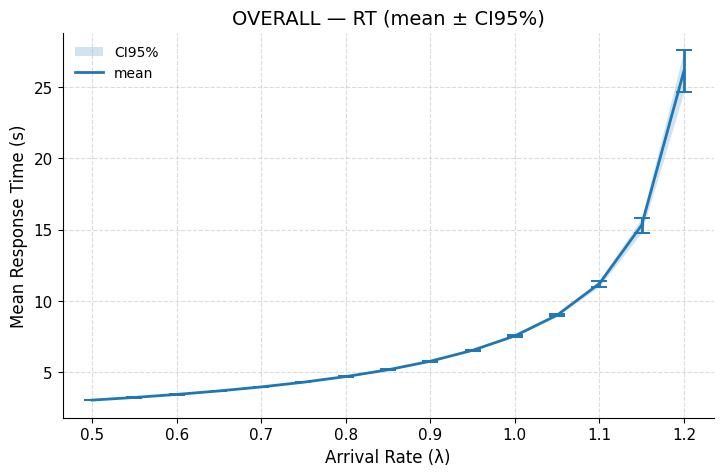

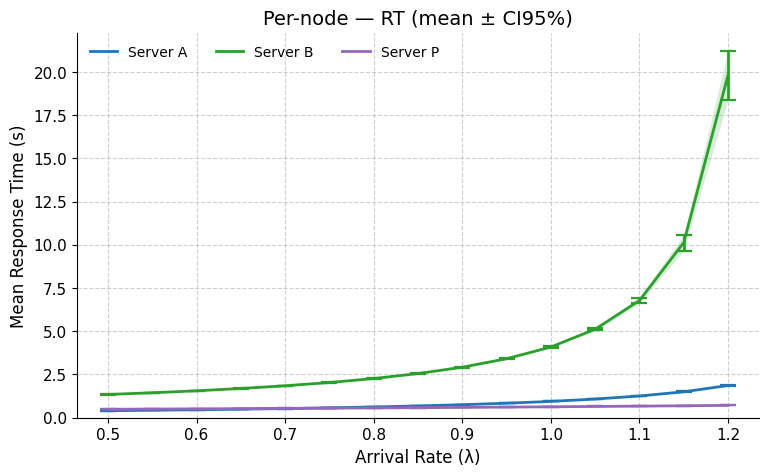

In [ ]:
# ===== Bloccone snello: load -> sanity -> aggregate (OVERALL & NODI) + plot CI =====

import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

paper_theme()  # tema una volta

# ------------------------ LOAD (riusa load_runs) ------------------------
pattern = r".output_simulation/results_obj1_arrivals_run*.csv"
files = sorted(glob.glob(pattern))
if not files:
    raise FileNotFoundError(f"Nessun CSV trovato per: {pattern}")
df_all = load_runs(files)  # aggiunge 'replica','source' e normalizza colonne

# ------------------------ SANITY CHECKS ------------------------
def sanity_checks(df_all: pd.DataFrame):
    print("Scopes presenti:", sorted(df_all["scope"].dropna().unique().tolist()))
    if "arrival_rate" not in df_all.columns:
        raise ValueError("Manca la colonna 'arrival_rate' nei CSV.")
    overall = df_all[df_all["scope"] == "OVERALL"].copy()
    dup = overall.duplicated(subset=["replica", "arrival_rate"], keep=False)
    if dup.any():
        print("[WARN] Duplicati OVERALL per (replica, λ):")
        print(overall.loc[dup, ["replica","arrival_rate","source"]].head(10))
    counts = overall.groupby("arrival_rate").size()
    print("Repliche OVERALL per λ:", counts.to_dict())

sanity_checks(df_all)

# ------------------------ AGGREGATI (riusa agg_ci) ------------------------
overall = df_all[df_all["scope"] == "OVERALL"].copy()
G_over_rt = agg_ci(overall, x="arrival_rate", y="mean_response_time")
if "throughput" in overall.columns:
    G_over_x  = agg_ci(overall, x="arrival_rate", y="throughput")
else:
    G_over_x = None

nodes = df_all[df_all["scope"].isin(["NODE_A","NODE_B","NODE_P"])].copy()

# ------------------------ TABELLE DI SINTESI ------------------------
print("\n--- OVERALL (mean ± CI tra repliche) ---")
cols = ["arrival_rate","mean","ci_lo","ci_hi","n"]
display(G_over_rt[cols].rename(columns={
    "mean":"rt_mean","ci_lo":"rt_lo","ci_hi":"rt_hi","n":"n_reps"
}).round(4))

if G_over_x is not None:
    print("\n--- OVERALL Throughput (mean ± CI) ---")
    display(G_over_x[cols].rename(columns={
        "mean":"x_mean","ci_lo":"x_lo","ci_hi":"x_hi","n":"n_reps"
    }).round(4))

# Per nodo: tabella compatta (media e CI) per ogni (λ, nodo)
G_nodes = []
for scope, g in nodes.groupby("scope"):
    s = agg_ci(g, x="arrival_rate", y="mean_response_time")
    s = s.assign(scope=scope)
    G_nodes.append(s)
G_nodes = pd.concat(G_nodes, ignore_index=True) if G_nodes else pd.DataFrame()

if not G_nodes.empty:
    print("\n--- NODI (mean ± CI tra repliche) ---")
    display(G_nodes[["arrival_rate","scope","mean","ci_lo","ci_hi","n"]].round(4))

# ------------------------ PLOT (riusa util) ------------------------
# OVERALL: RT
line_with_ci(
    overall, x="arrival_rate", y="mean_response_time",
    title="OVERALL — RT (mean ± CI95%)",
    xlabel="Arrival Rate (λ)", ylabel="Mean Response Time (s)"
)

# OVERALL: Throughput (se disponibile)
if G_over_x is not None:
    line_with_ci(
        overall, x="arrival_rate", y="throughput",
        title="OVERALL — Throughput (mean ± CI95%)",
        xlabel="Arrival Rate (λ)", ylabel="Throughput (req/s)"
    )

# NODI: RT con small multiples + banda CI
if not nodes.empty:
    nodes_small_multiples(
        nodes, x="arrival_rate", y="mean_response_time",
        xlabel="Arrival Rate (λ)", ylabel="Mean Response Time (s)",
        suptitle="Per-node — RT (mean ± CI95%)"
    )


In [ ]:
# con stima automatica dei D dai dati
plot_rt_theory_overlay(df_all, title_prefix="OBJ1")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_overall_with_zoom(df_all: pd.DataFrame,
                           D_tuple: tuple[float, float, float] | None = None,
                           zoom_max: float = 1.05,
                           title_prefix: str = "OVERALL"):
    """
    Confronto teoria vs simulazione in due pannelli (full + zoom).
    Riusa le util comuni:
      - estimate_demands_from_df, aggregate_sim_overall, theoretical_R
    Non ricalcola CI: usa quelle già stimate dall'aggregazione.
    """
    # dati OVERALL
    df_overall = df_all[df_all["scope"] == "OVERALL"].copy()
    if df_overall.empty or "mean_response_time" not in df_overall.columns:
        print("Mancano dati OVERALL/mean_response_time."); return

    # Demand e X_sat
    if D_tuple is None:
        D_est = estimate_demands_from_df(df_all)
        D = {"D_A": D_est.get("D_A", 0.0), "D_B": D_est.get("D_B", 0.0), "D_P": D_est.get("D_P", 0.0)}
        X_sat = D_est.get("X_sat", np.inf)
    else:
        D = {"D_A": float(D_tuple[0]), "D_B": float(D_tuple[1]), "D_P": float(D_tuple[2])}
        X_sat = 1.0 / max(D.values())

    # Aggregazione simulazione (mean ± CI) e asse x coerente
    agg, xcol, xlabel = aggregate_sim_overall(df_overall)
    x = agg[xcol].to_numpy(float)
    y = agg["mean"].to_numpy(float)
    ylo = np.where(np.isfinite(agg["ci_lo"]), agg["ci_lo"], agg["mean"])
    yhi = np.where(np.isfinite(agg["ci_hi"]), agg["ci_hi"], agg["mean"])
    yerr = np.vstack([y - ylo, yhi - y])  # asimmetrico

    # Griglie teoriche
    x_min, x_max = float(np.nanmin(x)), float(np.nanmax(x))
    full_right = min(X_sat * 0.995, max(1e-6, x_max) * 1.05)
    full_left  = max(1e-6, 0.9 * x_min)
    grid_full  = np.linspace(full_left, full_right, 500)
    R_full     = theoretical_R(grid_full, D)

    grid_zoom = grid_full[grid_full <= zoom_max]
    R_zoom    = R_full[:len(grid_zoom)]
    mask_zoom = x <= zoom_max

    # Plot: due pannelli
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.8), sharey=True)

    # pannello 1: full range
    ax = axes[0]
    ax.plot(grid_full, R_full, lw=1.8, label="Teoria (M/M/1 in serie)")
    ax.plot(x, y, "-", lw=2.0, label="Sim (mean)")
    ax.errorbar(x, y, yerr=yerr, fmt="none", ecolor="C1", elinewidth=2.0, capsize=6, capthick=1.5)
    ax.axvline(X_sat, ls="--", lw=1.2, color="gray", alpha=0.6, label=f"X_sat ≈ {X_sat:.3f}")
    ax.set_xlabel(xlabel); ax.set_ylabel("Mean Response Time (s)")
    ax.set_title(f"{title_prefix} — RT (full)")
    ax.grid(True, ls="--", alpha=0.35); ax.legend()

    # pannello 2: zoom
    ax = axes[1]
    ax.plot(grid_zoom, R_zoom, lw=1.8, label="Teoria (M/M/1 in serie)")
    ax.plot(x[mask_zoom], y[mask_zoom], "-", lw=2.0, label="Sim (mean)")
    ax.errorbar(x[mask_zoom], y[mask_zoom], yerr=yerr[:, mask_zoom], fmt="none",
                ecolor="C1", elinewidth=2.0, capsize=6, capthick=1.5)
    ax.axvline(X_sat, ls="--", lw=1.2, color="gray", alpha=0.6)
    ax.set_xlabel(xlabel); ax.set_title(f"{title_prefix} — RT (zoom λ≤{zoom_max})")
    ax.grid(True, ls="--", alpha=0.35); ax.legend()

    plt.tight_layout(); plt.show()


In [ ]:
# stima automatica dei demand
plot_rt_theory_overlay(df_all, title_prefix="OVERALL")


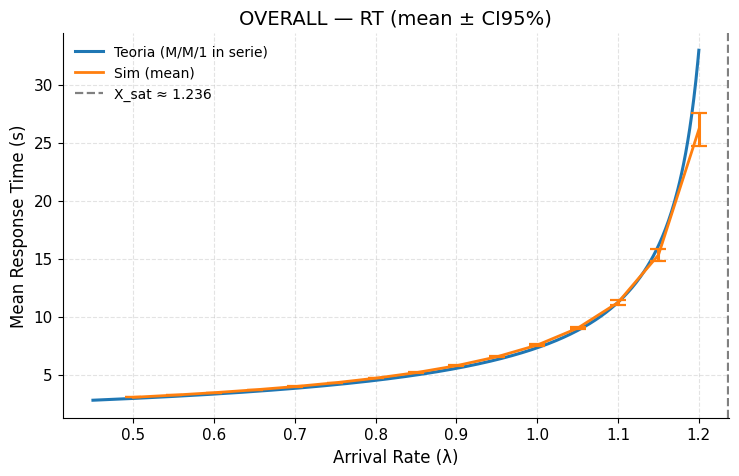

In [137]:
# Se D è una tupla (D_A, D_B, D_P)
D_A, D_B, D_P = D
X_sat = 1.0 / max(D_A, D_B, D_P)

# chiamata unica
plot_overall_with_theory(G_over, D_A=D_A, D_B=D_B, D_P=D_P, X_sat=X_sat)


In [138]:
df_overall_mean

,arrival_rate,mean_response_time,std_response_time,mean_population,std_population,throughput,utilization,std_response_time_cov,std_population_cov
0,0.50,7.246797,4.610529,7.055622,5.556065,0.849718,0.886852,4.610532,4.617785
1,0.85,9.080972,5.955763,9.394226,7.300720,0.878949,0.896247,5.955763,6.304204
2,0.90,8.777249,5.409840,9.023911,6.624650,0.876550,0.894555,5.409872,5.656958
3,0.95,9.399777,6.333074,9.713816,7.736783,0.869897,0.892667,6.333094,6.715999
4,1.00,8.688600,5.481102,8.880606,6.712392,0.866855,0.891220,5.481241,5.715108
5,1.05,8.727444,5.763484,8.946328,7.032120,0.865861,0.890459,5.763499,6.061317
6,1.10,8.699132,5.997104,8.861191,7.279794,0.858812,0.887810,5.997111,6.297551
7,1.15,9.963090,6.946515,10.407798,8.461283,0.861280,0.892419,6.946559,7.489127
8,1.20,7.896068,5.113379,7.851759,6.177280,0.852730,0.889496,5.113421,5.210018


In [139]:
df_all[df_all["arrival_rate"]==1.2]

,scope,arrival_rate,mean_response_time,std_response_time,mean_population,std_population,throughput,utilization,std_response_time_cov,std_population_cov,seed,source
56,OVERALL,1.2,24.742547,17.701349,29.596634,22.198682,1.199963,0.997158,17.701355,21.240973,314159265,results_obj1_arrivals_run000_seed314159265_202...
57,NODE_A,1.2,1.857512,1.912421,6.593600,7.365156,3.599870,0.849168,NaN,NaN,314159265,results_obj1_arrivals_run000_seed314159265_202...
58,NODE_B,1.2,18.454906,17.308179,22.144935,21.204121,1.199962,0.968787,NaN,NaN,314159265,results_obj1_arrivals_run000_seed314159265_202...
59,NODE_P,1.2,0.715106,0.717656,0.858100,1.217840,1.199962,0.484430,NaN,NaN,314159265,results_obj1_arrivals_run000_seed314159265_202...
60,OVERALL,1.2,27.184722,20.103911,32.593611,25.183269,1.202270,0.997428,20.103917,24.170340,271828183,results_obj1_arrivals_run015_seed271828183_202...
61,NODE_A,1.2,1.874510,1.946989,6.671738,7.505863,3.606768,0.850061,NaN,NaN,271828183,results_obj1_arrivals_run015_seed271828183_202...
62,NODE_B,1.2,20.844918,19.736370,25.060720,24.234524,1.202259,0.972259,NaN,NaN,271828183,results_obj1_arrivals_run015_seed271828183_202...
63,NODE_P,1.2,0.716273,0.716808,0.861153,1.219034,1.202269,0.485776,NaN,NaN,271828183,results_obj1_arrivals_run015_seed271828183_202...
120,OVERALL,1.2,25.744220,19.619738,30.846196,24.632818,1.201561,0.997216,19.619761,23.574341,141421357,results_obj1_arrivals_run030_seed141421357_202...
121,NODE_A,1.2,1.882769,1.981929,6.700068,7.637253,3.604659,0.849244,NaN,NaN,141421357,results_obj1_arrivals_run030_seed141421357_202...
